# Deep Learning

## preprocessing training dataset

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from MLP import MLP

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

In [2]:
input_file_dir = "../datasets"
train_file_name = "kddcup.data_10_percent.txt"
test_file_name = "corrected.txt"
header_file_name = "header.txt"
train_files = os.path.join(input_file_dir, train_file_name)
test_files = os.path.join(input_file_dir, test_file_name)
header_files = os.path.join(input_file_dir, header_file_name)
with open(header_files, 'r') as f:
    header = f.readline().strip().split(',')
train_dataset = pd.read_csv(train_files)
test_dataset = pd.read_csv(test_files)
train_dataset.columns = header
test_dataset.columns = header

In [3]:
def labels_map(label):
    label = str(label).split('.')[0]
    if label == 'normal':
        return 0
    if label in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']: #PROBE
        return 1
    if label in ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']: #DOS
        return 2
    if label in ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']: #U2R
        return 3
    if label in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']: #R2L
        return 4
    
train_dataset['labels'] = train_dataset['labels'].apply(labels_map)
test_dataset['labels'] = test_dataset['labels'].apply(labels_map)

In [4]:
mask = train_dataset['labels']==0
print len(mask[mask==True]) # normal 
print len(mask[mask==False]) # DOS

mask = test_dataset['labels'] == 0
print len(mask[mask==True])
print len(mask[mask==False]) #1:4

97276
396744
60592
250436


In [5]:
#只保留DOS 和 Normal
train_dataset = train_dataset[(train_dataset['labels']==0) | (train_dataset['labels']==2)]
test_dataset = test_dataset[(test_dataset['labels']==0) | (test_dataset['labels'] == 2)]

In [6]:
#获取验证集
val_frac=0.25
valid_dataset_neg = train_dataset[(train_dataset['labels']==0)].sample(frac=val_frac)
valid_dataset_pos = train_dataset[(train_dataset['labels']==2)].sample(frac=val_frac)
valid_dataset = pd.concat([valid_dataset_neg, valid_dataset_pos], axis=0)

#train_dataset中分离出valid_dataset
train_dataset = train_dataset.select(lambda x: x not in valid_dataset.index, axis=0)


train_dataset_size = train_dataset.shape[0]
valid_dataset_size = valid_dataset.shape[0]
test_dataset_size = test_dataset.shape[0]

print 'Train dataset: ', train_dataset_size
print 'Valid dataset: ', valid_dataset_size
print 'Test  dataset: ', test_dataset_size

Train dataset:  366551
Valid dataset:  122184
Test  dataset:  290445


In [7]:
combine_dataset = pd.concat([train_dataset,valid_dataset, test_dataset], axis=0)

In [8]:
# labels独热编码
labels_dummies = pd.get_dummies(combine_dataset['labels'], prefix='label')
combine_dataset = pd.concat([combine_dataset,labels_dummies], axis=1)

In [9]:
combine_dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,label_0,label_2
0,0,tcp,http,SF,239,486,0,0,0,0,...,0.0,0.05,0.00,0.0,0.0,0.0,0.0,0,1,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,0.0,0.03,0.00,0.0,0.0,0.0,0.0,0,1,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0,1,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0,1,0
5,0,tcp,http,SF,212,1940,0,0,0,0,...,0.0,1.00,0.04,0.0,0.0,0.0,0.0,0,1,0


In [14]:
# 独热编码 protocol_type
print combine_dataset.protocol_type.value_counts()
protocal_type_dummies = pd.get_dummies(combine_dataset.protocol_type, prefix='protocol_type')

icmp    446898
tcp     296016
udp      36266
Name: protocol_type, dtype: int64


In [10]:
# Service 
# 共有66个 暂时先去掉
# combine_dataset.service.value_counts()
# service_dummies = pd.get_dummies(combine_dataset.service, prefix='service')

In [15]:
# flag
print combine_dataset.flag.value_counts()
flag_dummies = pd.get_dummies(combine_dataset.flag, prefix='flag')

SF        606989
S0        104535
REJ        64983
RSTO        1498
RSTR         764
S3           292
S1            74
S2            43
RSTOS0         1
OTH            1
Name: flag, dtype: int64


In [12]:
# src_bytes & dst_bytes 去中心化

# Method 1: 去中心化
combine_dataset['src_bytes_norm'] = combine_dataset.src_bytes - combine_dataset.src_bytes.mean()
combine_dataset['dst_bytes_norm'] = combine_dataset.dst_bytes - combine_dataset.dst_bytes.mean()

# Method 2: 规范化
# max1 = combine_dataset.src_bytes.max(); min1 = combine_dataset.src_bytes.min();
# max2 = combine_dataset.dst_bytes.max(); min2 = combine_dataset.dst_bytes.min();
# combine_dataset['src_bytes_norm'] = (combine_dataset.src_bytes - min1) / float(max1 - min1)
# combine_dataset['dst_bytes_norm'] = (combine_dataset.dst_bytes - min2) / float(max2 - min2)

In [16]:
# 组合
# 各个独热编码 protocal_type, flag , 暂时去掉 service_dummies
combine_dataset = pd.concat([combine_dataset, protocal_type_dummies, flag_dummies], axis=1)

# 删除不用的属性
combine_dataset = combine_dataset.drop(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes','labels'], axis=1)
combine_dataset = combine_dataset.astype('float')

## preprocessing labels

In [17]:
#分离出Train Valid Test 
sub_train_dataset = combine_dataset.iloc[:train_dataset_size, :].sample(frac=1)
sub_valid_dataset = combine_dataset.iloc[train_dataset_size: train_dataset_size+valid_dataset_size, :].sample(frac=1)
sub_test_dataset = combine_dataset.iloc[train_dataset_size+valid_dataset_size:, :].sample(frac=1)
for i in range(4):
    sub_train_dataset.sample(frac=1, replace=True)
    sub_valid_dataset.sample(frac=1, replace=True)
    sub_test_dataset.sample(frac=1, replace=True)

In [18]:
# 分离出 label
sub_train_labels = sub_train_dataset[['label_0', 'label_2']] # Normal DOS
sub_valid_labels = sub_valid_dataset[['label_0', 'label_2']]
sub_test_labels = sub_test_dataset[['label_0', 'label_2']]
sub_train_dataset.drop(['label_0',  'label_2'], axis=1, inplace=True)
sub_valid_dataset.drop(['label_0', 'label_2'], axis=1, inplace=True)
sub_test_dataset.drop(['label_0', 'label_2'], axis=1, inplace=True)

# sub_train_labels = sub_train_dataset[['label_0', 'label_1', 'label_2', 'label_3', 'label_4']]
# sub_test_labels = sub_test_dataset[['label_0', 'label_1', 'label_2', 'label_3', 'label_4']]
# sub_train_dataset.drop(['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], axis=1, inplace=True)
# sub_test_dataset.drop(['label_0', 'label_1', 'label_2', 'label_3', 'label_4'], axis=1, inplace=True)

print 'Sub Trian: ', sub_train_dataset.shape, sub_train_labels.shape
print 'Sub Valid: ', sub_valid_dataset.shape, sub_valid_labels.shape
print 'Sub Test : ', sub_test_dataset.shape, sub_test_labels.shape

Sub Trian:  (366551, 51) (366551, 2)
Sub Valid:  (122184, 51) (122184, 2)
Sub Test :  (290445, 51) (290445, 2)


## model1: MLP

In [19]:
data = {
    'X_train': sub_train_dataset.values[:,:],
    'y_train': sub_train_labels.values[:,:],
    'X_val': sub_valid_dataset.as_matrix(),
    'y_val': sub_valid_labels.as_matrix(),
    'X_test': sub_test_dataset.as_matrix(),
    'y_test': sub_test_labels.as_matrix()
}
for k, v in data.iteritems():
    print k, v.shape

X_val (122184, 51)
X_train (366551, 51)
X_test (290445, 51)
y_val (122184, 2)
y_train (366551, 2)
y_test (290445, 2)


In [20]:
input_dim = data['X_train'].shape[1]
output_dim = data['y_train'].shape[1]
model = MLP(data, input_dim, [512],output_dim,
            learning_rate=1e-5, #1e-6
            dropout_prob=0.0,
            l2_strength=0.0,
            batch_size=200,
            num_epochs=15,
            print_every=500,
            verbose=True)

In [21]:
model.train()

(Iteration 0 / 27480) train acc: 25.00%; val_acc: 26.71%; test_acc: 34.64%
(Iteration 500 / 27480) train acc: 99.00%; val_acc: 99.32%; test_acc: 97.20%
(Iteration 1000 / 27480) train acc: 100.00%; val_acc: 99.53%; test_acc: 95.92%
(Iteration 1500 / 27480) train acc: 100.00%; val_acc: 99.51%; test_acc: 97.99%
(Iteration 2000 / 27480) train acc: 100.00%; val_acc: 99.69%; test_acc: 97.17%
(Iteration 2500 / 27480) train acc: 99.50%; val_acc: 99.64%; test_acc: 97.27%
(Iteration 3000 / 27480) train acc: 100.00%; val_acc: 99.68%; test_acc: 97.23%
(Iteration 3500 / 27480) train acc: 99.50%; val_acc: 99.72%; test_acc: 97.30%
(Iteration 4000 / 27480) train acc: 100.00%; val_acc: 99.76%; test_acc: 97.33%
(Iteration 4500 / 27480) train acc: 99.50%; val_acc: 99.62%; test_acc: 97.26%
(Iteration 5000 / 27480) train acc: 100.00%; val_acc: 99.75%; test_acc: 97.32%
(Iteration 5500 / 27480) train acc: 100.00%; val_acc: 99.54%; test_acc: 97.26%
(Iteration 6000 / 27480) train acc: 100.00%; val_acc: 99.62%;

[]

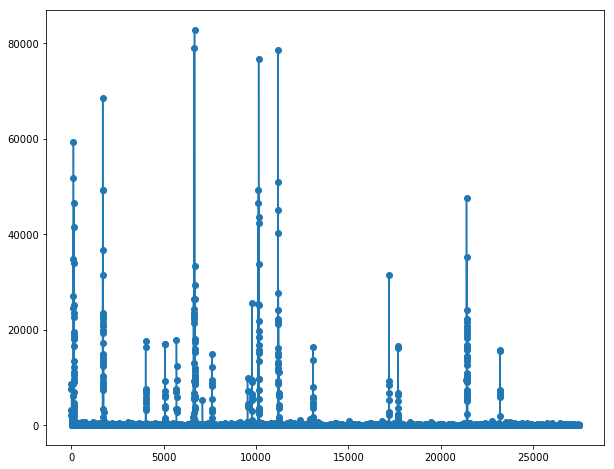

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(len(model.loss_history)), model.loss_history, '-o')
plt.plot()

55
0.983364 0.983702 0.958394


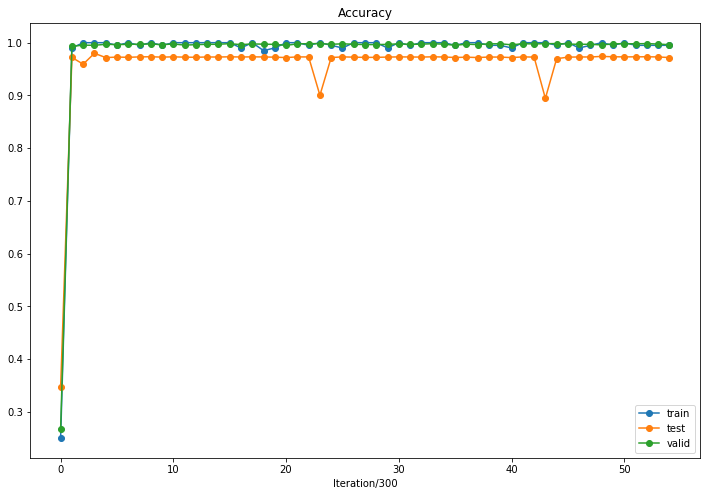

In [23]:
plt_len = len(model.train_acc_history)
print plt_len
print np.mean(model.train_acc_history), np.mean(model.val_acc_history), np.mean(model.test_acc_history)
plt.subplot(1,1,1)
plt.title('Accuracy')
plt.plot(model.train_acc_history, '-o', label='train')
plt.plot(model.test_acc_history, '-o', label='test')
plt.plot(model.val_acc_history, '-o', label='valid')
# plt.plot([90] * plt_len, 'k--')
plt.xlabel('Iteration/300')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(12,8)
plt.show()

## Analysis

In [24]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [25]:
#统计每个列别的precision TP/(TP + FN)检测率   Recall: TP/(TP + FP)对应误报率

#negative对应的是正常的，positive对应的是attack.以此转换成二分类问题
def precission_recall(predictions, actuals, negative=[0], positive=[1,2,3,4]):
    pred_labels = np.argmax(predictions,axis=1)
    actual_labels = np.argmax(actuals, axis=1)
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    test_size = predictions.shape[0]
    for i in xrange(test_size):
        if pred_labels[i] in positive:
            if actual_labels[i] in positive:
                TP += 1.0
            else:
                FP += 1.0
        else:
            if actual_labels[i] in negative:
                TN += 1.0
            else:
                FN += 1.0
    if TP + FN == 0:
        print 'There is no positive in test'
        precission = -1
    else:
        precission = TP / (TP + FN)
    if TP + FP == 0:
        print 'There is no positive in the prediction'
        recall = -1
    else:
        recall = TP / (TP + FP)
    return precission, recall

In [26]:
#normal: 0 PROBE:1 DOS:2 U2R:3 R2L:4 Positive:1-4攻击； Negative:0 正常；
last_test_pred = model.prediction(data['X_test'])
last_test_pred_idx = np.argmax(last_test_pred, axis=1)
sub_test_idx = np.argmax(sub_test_labels.values[::],axis=1)
print last_test_pred_idx.shape, sub_test_idx.shape

precission, recall = precission_recall(last_test_pred, sub_test_labels.values[::], negative=[0], positive=[1])

print '检测率: %.2f%%' % (precission * 100)
print '误报率： %.2f%%' % (100 - recall * 100)

AttributeError: 'MLP' object has no attribute 'prediction'

In [ ]:
print 'Test'
print len(sub_test_labels)
print '0:', np.sum(sub_test_labels.label_0 == 1)
# print '1:', np.sum(sub_test_labels.label_1 == 1)
print '2:', np.sum(sub_test_labels.label_2 == 1)
# print '3:', np.sum(sub_test_labels.label_3 == 1)
# print '4:', np.sum(sub_test_labels.label_4 == 1)

In [ ]:
pred = np.argmax(last_test_pred, axis=1)
print 'Prediction'
print 'tot:', pred.shape[0]
print '0:', pred[pred==0].shape[0]
print '1:', pred[pred==1].shape[0]
# print '2:', pred[pred==2].shape[0]
# print '3:', pred[pred==3].shape[0]
# print '4:', pred[pred==4].shape[0]